In [1]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

/home/sanjeev/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy'' # Data Path 
base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/asm_images/'
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [3]:
# classes in malimg data
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [4]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


In [ ]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [4]:
# Using Mobile net V1 as base model for feature extraction 

In [9]:
bytes_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_bytes_microsoft_1024.npy')
asm_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_asm_microsoft_1024.npy')

In [10]:
bytes_features.shape, asm_features.shape

((10868, 1024), (10868, 1024))

In [11]:
X = []
for i in range(len(asm_features)):
    x = list(np.hstack((asm_features[i], bytes_features[i])))
    X.append(x)

In [12]:
X =  np.array(X)
X.shape

(10868, 2048)

## Classification using KNN(K-Nearest Neighbors)

In [33]:
import pandas as pd
import disarray as da
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [35]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 2048)
Y_Train: (8585,)
X_Test: (2283, 2048)
Y_Test: (2283,)


In [36]:
# X_train = X_train // 255.0
# X_test = X_test // 255.0

In [37]:
knn = KNeighborsClassifier(leaf_size = 7, n_neighbors = 3,p = 1)

In [38]:
%%time
knn.fit(X_train,y_train)

CPU times: user 34.6 ms, sys: 0 ns, total: 34.6 ms
Wall time: 33.2 ms


KNeighborsClassifier(leaf_size=7, n_neighbors=3, p=1)

In [39]:
print("Testing Accuracy:", round((knn.score(X_test, y_test) * 100), 2))

Testing Accuracy: 91.33


In [40]:
%%time
y_pred = knn.predict(X_test)

CPU times: user 35.6 s, sys: 135 ms, total: 35.7 s
Wall time: 35.7 s


In [21]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

91 91 91
CPU times: user 4.94 ms, sys: 63 µs, total: 5.01 ms
Wall time: 3.79 ms


In [22]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94       230
         1.0       0.93      0.94      0.93        80
         2.0       1.00      1.00      1.00       623
         3.0       0.94      0.85      0.89       558
         4.0       0.89      0.94      0.92       231
         5.0       0.76      0.89      0.82       283
         6.0       0.00      0.00      0.00         0
         7.0       0.78      0.73      0.75       166
         8.0       0.97      0.97      0.97       112

    accuracy                           0.91      2283
   macro avg       0.80      0.81      0.80      2283
weighted avg       0.92      0.91      0.92      2283



In [1]:
data = [
    {"Class": "Gatak", "Precision": 0.87, "Recall": 0.76, "F1-Score": 0.81, "Support": 261},
    {"Class": "Kelihos_ver1", "Precision": 0.95, "Recall": 0.92, "F1-Score": 0.93, "Support": 85},
    {"Class": "Kelihos_ver3", "Precision": 0.97, "Recall": 0.91, "F1-Score": 0.94, "Support": 682},
    {"Class": "Lollipop", "Precision": 0.90, "Recall": 0.90, "F1-Score": 0.90, "Support": 512},
    {"Class": "Obfuscator.ACY", "Precision": 0.86, "Recall": 0.93, "F1-Score": 0.89, "Support": 228},
    {"Class": "Ramnit", "Precision": 0.94, "Recall": 0.94, "F1-Score": 0.94, "Support": 316},
    {"Class": "Simda", "Precision": 0.22, "Recall": 1.00, "F1-Score": 0.36, "Support": 2},
    {"Class": "Tracur", "Precision": 0.74, "Recall": 0.84, "F1-Score": 0.78, "Support": 134},
    {"Class": "Vundo", "Precision": 0.42, "Recall": 0.70, "F1-Score": 0.52, "Support": 63},
]
precision_values = [item["F1-Score"] for item in data]
for value in precision_values:
    print(value)

0.81
0.93
0.94
0.9
0.89
0.94
0.36
0.78
0.52


In [28]:
# GridSearchCV

In [47]:
param_grid = {'n_neighbors': range(1, 11),
              'metric': ['euclidean', 'manhattan', 'chebyshev']}

In [48]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

CPU times: user 84 µs, sys: 21 µs, total: 105 µs
Wall time: 117 µs


In [49]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 54min 21s, sys: 12min 35s, total: 1h 6min 57s
Wall time: 41min 9s


GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(leaf_size=7, n_neighbors=3, p=1),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': range(1, 11)},
             scoring='accuracy')

In [50]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1}


In [ ]:
# to be added in remaining code

print("Accuracy on testing set: {:.3f}".format(grid_search.score(X_test, y_test)))

In [ ]:
y_pred = grid_search.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

In [ ]:
list_fams = sorted(label_dict.keys())

In [ ]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_KNN_asm.csv')

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_KNN_asm.eps', bbox_inches='tight')
plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_KNN_asm.png', bbox_inches='tight')

plt.show()

In [38]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [39]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [40]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [41]:
FP, FN, TP, TN

(array([15,  4,  1, 52, 10, 36,  6, 46,  2]),
 array([ 8,  4,  3, 36, 20, 70,  6, 23,  2]),
 array([211,  77, 621, 471, 225, 262,   1, 133, 110]),
 array([2049, 2198, 1658, 1724, 2028, 1915, 2270, 2081, 2169]))

In [42]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.00388916, 0.00181653, 0.00180614, 0.02045455, 0.00976562,
       0.03526448, 0.0026362 , 0.01093156, 0.00092123])

In [43]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [44]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.963470,0.992733,0.007267,0.036530,0.066372,0.003889
Kelihos_ver1,0.950617,0.998183,0.001817,0.049383,0.049383,0.001817
Kelihos_ver3,0.995192,0.999397,0.000603,0.004808,0.001608,0.001806
Lollipop,0.928994,0.970721,0.029279,0.071006,0.099426,0.020455
Obfuscator.ACY,0.918367,0.995093,0.004907,0.081633,0.042553,0.009766
Ramnit,0.789157,0.981548,0.018452,0.210843,0.120805,0.035264
Simda,0.142857,0.997364,0.002636,0.857143,0.857143,0.002636
Tracur,0.852564,0.978373,0.021627,0.147436,0.256983,0.010932
Vundo,0.982143,0.999079,0.000921,0.017857,0.017857,0.000921


In [45]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 83.5929
Average of true_negative_rate --> 99.0277
Average of false_positive_rate --> 0.9723
Average of false_negative_rate --> 16.4071
Average of false_discovery_rate --> 16.8014
Average of false_omission_rate --> 0.9721


In [46]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

MCC Score: 0.91


In [47]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.9246605343845817
micro_recall : 0.9246605343845817
micro_f1_score : 0.9246605343845817


In [48]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.8319855220465863
macro_recall : 0.835929118902974
macro_f1_score : 0.8331734007897126


In [49]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [50]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [51]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

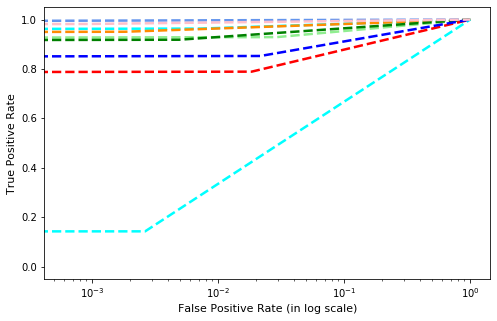

In [52]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_KNN_asm.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_KNN_asm.png", bbox_inches='tight')

plt.show()